In [4]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

#### 1. Загружаем ранее подготовленный датасет

In [5]:
# Загрузка csv файла
df = pd.read_csv('./new_train.csv', index_col = 0)
df.head()

,path,category,id_img,train_test
0,new_train/anger/1.jpg,anger,1.jpg,train
1,new_train/anger/10.jpg,anger,10.jpg,train
2,new_train/anger/100.jpg,anger,100.jpg,train
3,new_train/anger/1000.jpg,anger,1000.jpg,train
4,new_train/anger/1001.jpg,anger,1001.jpg,train


#### 2. Преобразование изображение в формат GRAY с последующей векторизацией 

In [7]:
# Уникальные значения категорий
uniq_category = df.category.unique()

# Функция которая преобразовывает изображение в вектор размером 2304
def img_to_48_gray(path_img):
    # Читаем изображение
    img = cv2.imread(path_img)
    # Конвертируем в черно-белый формат
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    # Изменяем изображение
    img = cv2.resize(img, (48, 48))
    return img.ravel() # возвращаем вектор 
    
# Итерируемся по категориями
for i_cat in uniq_category:
    temp_df = df[df['category']== i_cat]
    
    # Инициализируем выходной массив значений
    out_arr = None
    
    # Итерация по путям изображений
    for i_path in temp_df['path'].values:
        # Получаем выпрямленый вектор изображения 48 x 48
        vect = img_to_48_gray(i_path)
        if out_arr is None:
            # В случае, если это первый вектор
            out_arr = vect[None, ...]
        else:
            # Остальные векторы склеиваем 
            out_arr = np.concatenate((out_arr, vect[None, ...]), axis=0)
    
    # Присваиваем метки
    out_pd =  pd.DataFrame(out_arr)
    out_pd['path'] = [i for i in temp_df['path']]
    out_pd['train_test'] = [i for i in temp_df['train_test']]
    out_pd['id_img'] = [i for i in temp_df['id_img']]
    out_pd['category'] = i_cat
    # Сохраняем выходные данные по категориям
    out_pd.to_csv(f'./V_A_data/img_to_gray/{i_cat}.csv')
    print(f'out_pd {i_cat} save!')

out_pd anger save!
out_pd contempt save!
out_pd disgust save!
out_pd fear save!
out_pd happy save!
out_pd neutral save!
out_pd sad save!
out_pd surprise save!
out_pd uncertain save!


### Сформируем выборку состоящую из 1000 экземпляров каждого класса

In [8]:
# Количество экземпляров
num_sumples = 1000
new_pd = None
for i_va_data in os.listdir('./V_A_data/img_to_gray/'):
    temp_pd = pd.read_csv(f'./V_A_data/img_to_gray/{i_va_data}',index_col = 0)
    temp_pd = temp_pd.sample(frac=1).reset_index(drop=True).head(num_sumples)
    if new_pd is None:
        new_pd = temp_pd
    else:
        new_pd =  pd.concat([new_pd, temp_pd], axis=0)
        
# Сохраняем результаты
new_pd.to_csv('V_A_data/V_A_1000.csv')

#### Применим алгоритм ISOMAP (обучение на базе многообразий)


In [9]:
# Нормализуем данные
normalized_data = new_pd.iloc[:,:-4].values / 255
# Cj
isomap_model = Isomap(n_components=2)
isomap_model.fit(normalized_data)

Isomap()

In [10]:
# Теперь поочередно понизим размерность изображений
new_pd = None
for i_va_data in os.listdir('./V_A_data/img_to_gray'):
    temp_pd = pd.read_csv(f'./V_A_data/img_to_gray/{i_va_data}',index_col = 0)
    # Нормализуем данные
    normalized_data = temp_pd.iloc[:,:-4].values / 255
    # Понижаем размерность 
    transformed_data = pd.DataFrame(isomap_model.transform(normalized_data), columns=['Valence', 'Arousal'])
    temp_pd = pd.concat([temp_pd.iloc[:,-4:], transformed_data], axis=1)
    
    if new_pd is None:
        new_pd = temp_pd
    else:
        new_pd =  pd.concat([new_pd, temp_pd])
        
# Сохраняем результаты
new_pd.to_csv('./V_A_data/V_A_pre_train.csv')

In [11]:
new_pd = pd.read_csv('V_A_data/V_A_pre_train.csv', index_col= 0)
# Мы получили координаты, путем понижения размерности нелинейным способом используя ISOMAP - алгоритм на базе многообразий
# Теперь устраним отрицательные знаки в Valence и Arousal
new_pd.Valence = new_pd.Valence + abs(new_pd.Valence.min())
new_pd.Arousal = new_pd.Arousal + abs(new_pd.Arousal.min())
new_pd

,path,train_test,id_img,category,Valence,Arousal
0,new_train/anger/1.jpg,train,1.jpg,anger,28.208342,62.697904
1,new_train/anger/10.jpg,train,10.jpg,anger,60.416579,15.916085
2,new_train/anger/100.jpg,train,100.jpg,anger,61.486157,44.393255
3,new_train/anger/1000.jpg,train,1000.jpg,anger,38.237134,27.615682
4,new_train/anger/1001.jpg,train,1001.jpg,anger,63.535151,65.891103
...,...,...,...,...,...,...
6243,new_train/uncertain/656.jpg,train,656.jpg,uncertain,42.133591,22.232284
6244,new_train/uncertain/657.jpg,train,657.jpg,uncertain,86.210382,29.773568
6245,new_train/uncertain/658.jpg,train,658.jpg,uncertain,34.048770,51.818509
6246,new_train/uncertain/659.jpg,train,659.jpg,uncertain,36.355689,54.751799


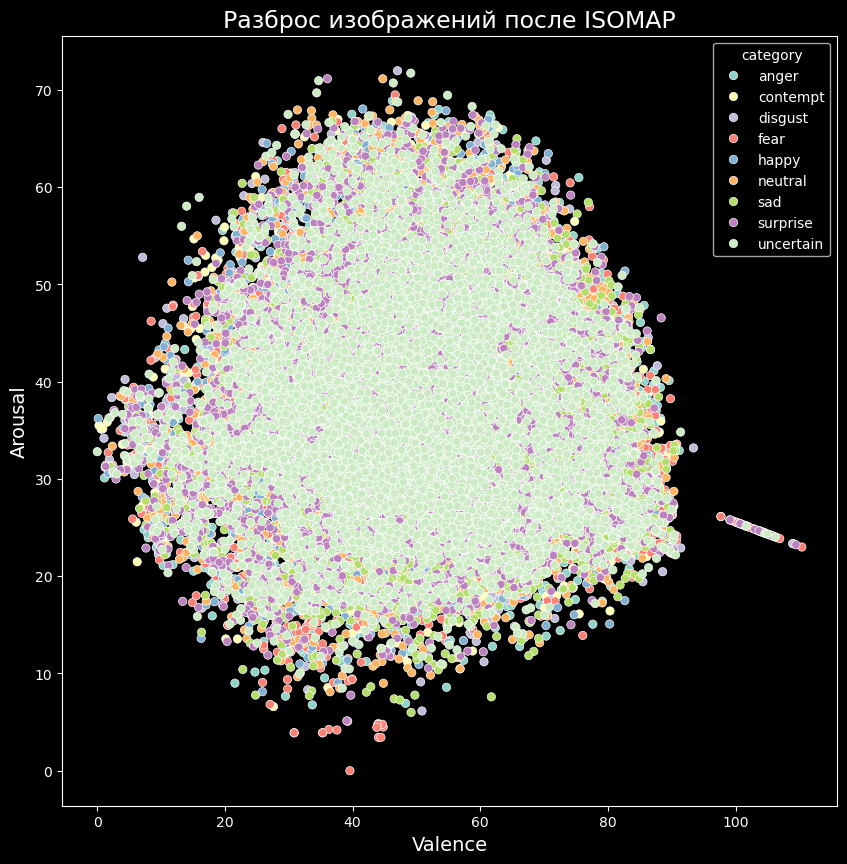

In [12]:
# Посмотрим что получилось
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(x = 'Valence', y = 'Arousal', data = new_pd, hue = 'category')
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Разброс изображений после ISOMAP', size=17)
plt.show()

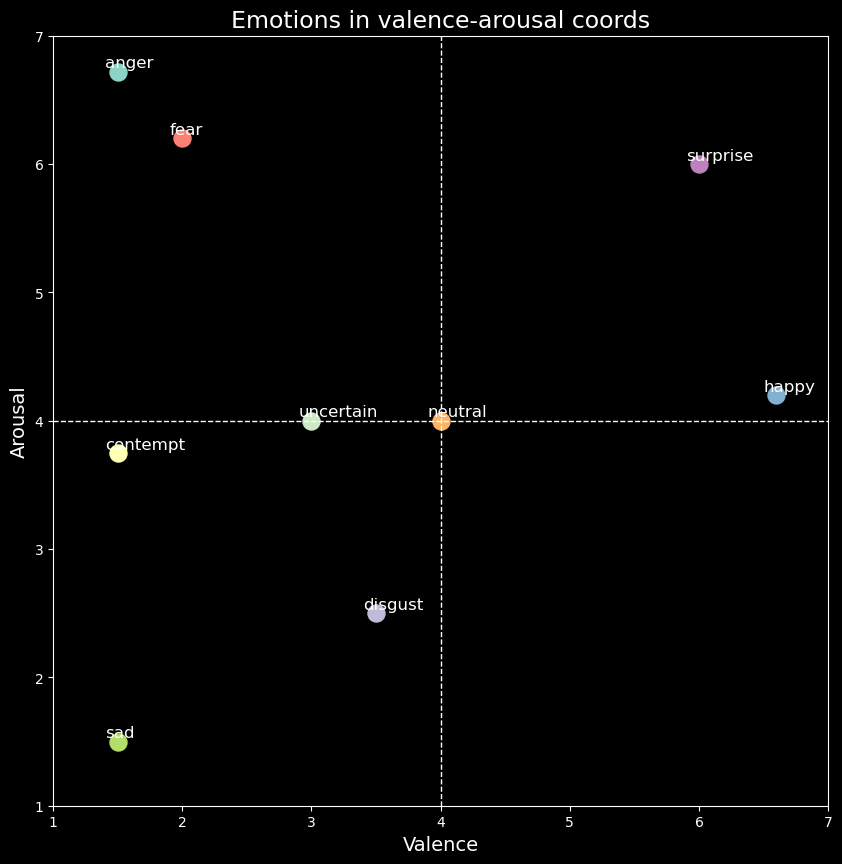

In [13]:
# На иной плоскости инициируем центры наших кластеров
VA_emotions = {
    'anger':    [ 1.5, 6.72],   # гнев
    'contempt': [ 1.5, 3.75],   # презрение
    'disgust':  [ 3.5,  2.5],   # отвращение
    'fear':     [ 2.0,  6.2],   # страх
    'happy':    [ 6.6,  4.2],   # радость
    'neutral':  [ 4.0,  4.0],   # безразличие
    'sad':      [ 1.5,  1.5],   # грусть
    'surprise': [ 6.0,  6.0],   # удивление
    'uncertain':[ 3.0,  4.0]    # неопределенность
}

# Нарисуем точки эмоций
fig, ax = plt.subplots(figsize=(10,10))
for emotion, (v, a) in VA_emotions.items():
    plt.scatter(v, a, label=emotion, s=150)
    plt.text(v-0.1, a+0.03, emotion, size=12)
plt.xlim(1,7)
plt.ylim(1,7)
plt.vlines(4, 1, 7, linestyle='dashed', lw=1)
plt.hlines(4, 1, 7, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Emotions in valence-arousal coords', size=17)
plt.show()


#### Перенос точек полученных через ISOMAP в текущую плоскость

In [14]:
### Исходя из того, что центром является эмоция neutral, найдем центр распределения по ISOMAP и расчитаем коэфициент для переноса центров кластеров 
coef_val = 4. / new_pd.Valence.mean()
coef_aro = 4. / new_pd.Arousal.mean()
print(coef_val)
print(coef_aro)
# ПРименим коэфициенты к полученным значениям val and aro Isomap
new_pd.Valence = new_pd.Valence * coef_val
new_pd.Arousal = new_pd.Arousal * coef_aro

0.07921371406925656
0.1092682343929863


#### Применим подходы алгоритма кластеризации k-means - но в нашем случае, центры кластеров - фиксированы и смещениек к ним будут проводить экземпляры класса.


In [15]:
# Функция смещения жкземпляров к центрам своих кластеров в зависимости от расстояния от своего кластера
def step_home(df=None, clusters=VA_emotions, step_per=0.1):
    out_pd = None
    for i_class in df.category.unique():
        tdf =  df[df.category == i_class].copy()
        V_A = tdf[['Valence', 'Arousal']].values
        VA_i_class_coordinates = np.array([VA_emotions[i_class]])
        # Нужен для расчета коэфициента скорости изменения координат
        dist = pairwise_distances(V_A, VA_i_class_coordinates, metric='euclidean')
        # полуаем среднее значение dist
        mean_ds = dist.mean()
        # Длина шага для каждого из экземпляров в зависимости от удаления от центра кластера
        step_cof = dist / mean_ds * step_per
        #Посчитаем разницу между точкой и центром кластера
        new_V_A = V_A + ((VA_i_class_coordinates - V_A) * step_cof)
        tdf[['Valence', 'Arousal']] = new_V_A
        if out_pd is None:
            out_pd = tdf
        else:
            out_pd = pd.concat([out_pd, tdf], ignore_index=True)
        
    return out_pd

def show_step(df=None, step_n =None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(x = 'Valence', y = 'Arousal', data = df, hue = 'category')
    plt.xlabel('Valence', size=14)
    plt.ylabel('Arousal', size=14)
    plt.title(f'Разброс изображений после {step_n}-го шага схождения', size=17)
    plt.show()

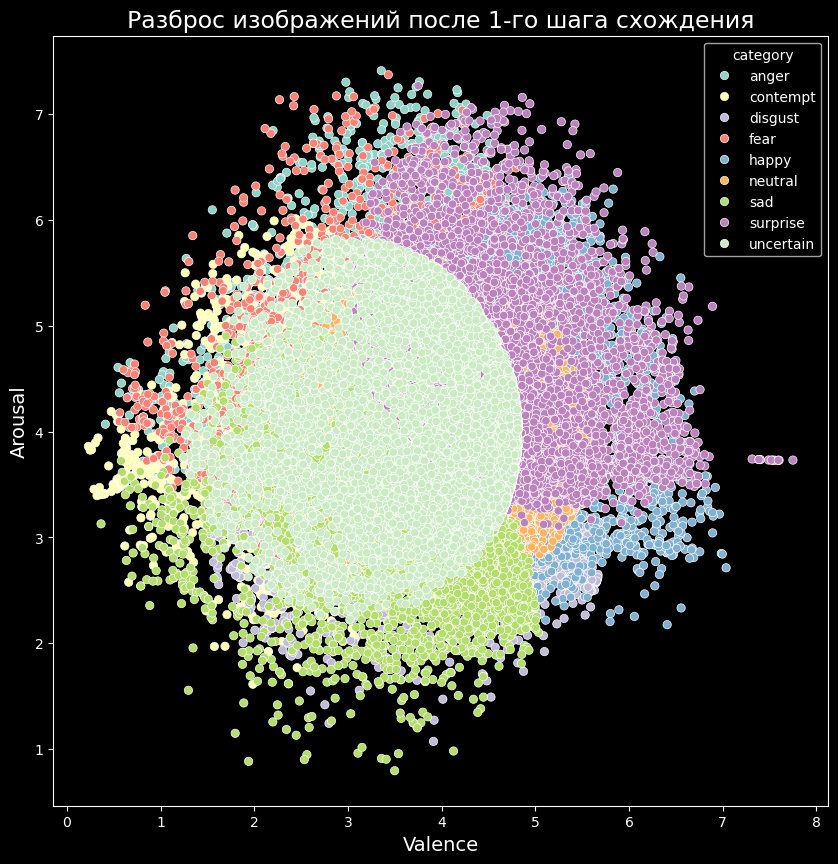

In [16]:
# ШАГ 1-й
step_df = step_home(df=new_pd, clusters=VA_emotions, step_per=0.25)
show_step(df=step_df,
         step_n=1)

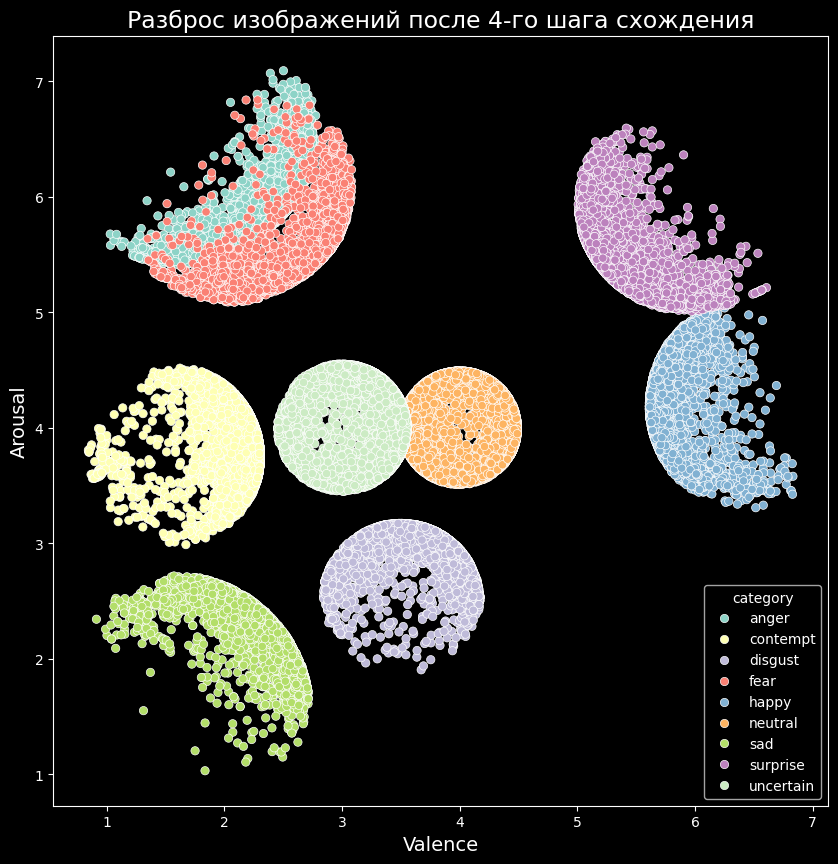

In [17]:
# ШАГ 4-й
for i in range(3):
    step_df = step_home(df=step_df, clusters=VA_emotions, step_per=0.25)
show_step(df=step_df,
         step_n=4)

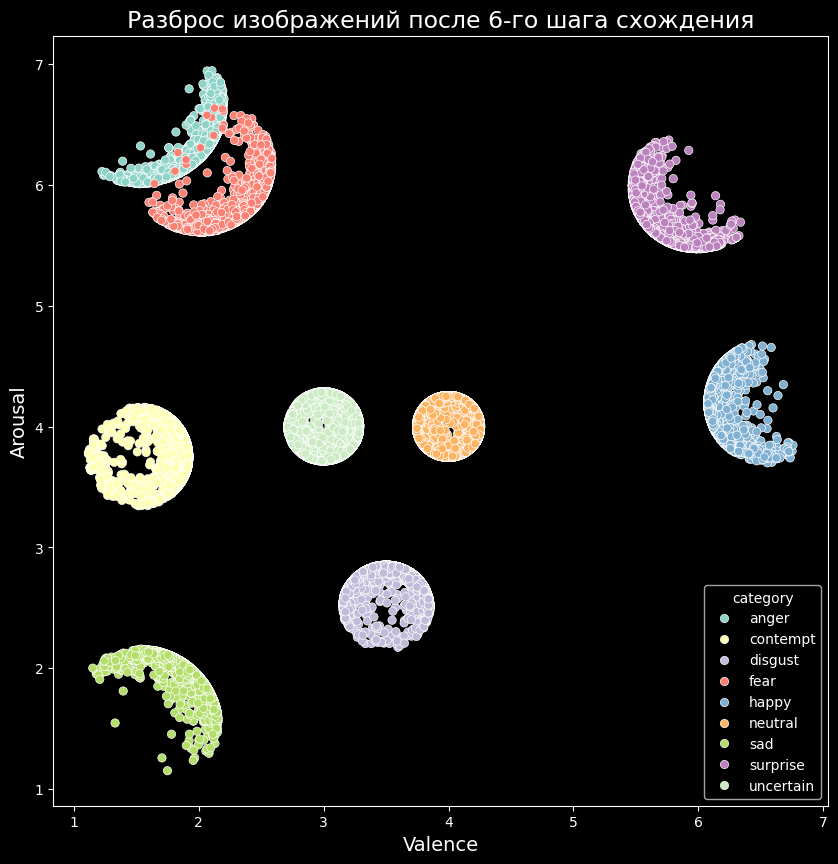

In [18]:
# ШАГ 6-й
for i in range(2):
    step_df = step_home(df=step_df, clusters=VA_emotions, step_per=0.25)
show_step(df=step_df,
         step_n=6)

In [19]:
#Сохраняем размеченные значения для дальнейшего обучения
step_df.to_csv('V_A_data/V_A_train.csv')